In [7]:
import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from itertools import combinations

# Load the Labeled Faces in the Wild dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Function to create pairs of images for training
def create_pairs(x, digit_indices):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(n_classes)]) - 1
    for d in range(n_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, n_classes)
            dn = (d + inc) % n_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

# Create training and testing pairs
digit_indices = [np.where(y_train == i)[0] for i in range(n_classes)]
tr_pairs, tr_y = create_pairs(X_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(n_classes)]
te_pairs, te_y = create_pairs(X_test, digit_indices)

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.regularizers import l2

def initialize_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(2e-4))(input)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(2e-4))(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(x)
    return Model(input, x)

input_shape = (X_train.shape[1], X_train.shape[2], 1)
base_network = initialize_base_network(input_shape)

IndexError: tuple index out of range

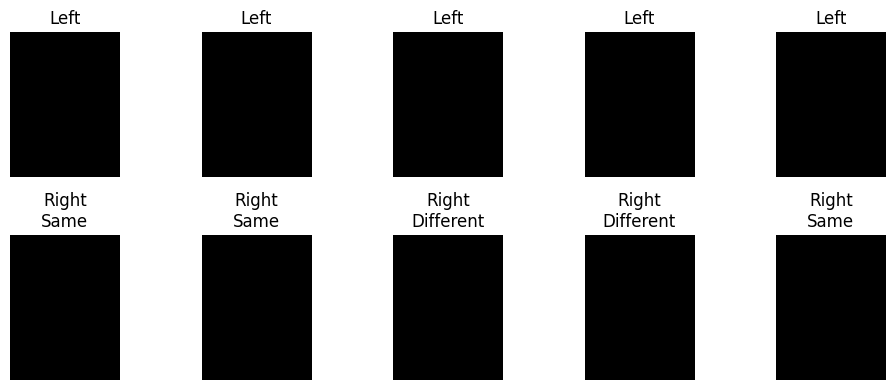

In [ ]:
# Create the Siamese network for binary cross-entropy
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(lambda embeddings: tf.abs(embeddings[0] - embeddings[1]))([processed_a, processed_b])
outputs = Dense(1, activation='sigmoid')(distance)
model_bce = Model([input_a, input_b], outputs)

model_bce.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
# model_bce.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
#             batch_size=128,
#             epochs=10,
#             validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

In [ ]:
def create_encoder():
    model = keras.Sequential([
        layers.Input(shape=(62, 47, 3)),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))  # normalize embeddings
    ])
    return model
